In [1]:
import opensmile
import pandas as pd
import os
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
#from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


import audiofile

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


### Ravdess Dataframe

In [2]:
# Paths for data.
Ravdess = r'data'

#Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [3]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(os.path.join(Ravdess, dir))
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        #file_path.append(Ravdess + dir + '/' + file)
        file_path.append(os.path.join(Ravdess, dir, file))
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head(15)

,Emotions,Path
0,neutral,data\Actor_01\03-01-01-01-01-01-01.wav
1,neutral,data\Actor_01\03-01-01-01-01-02-01.wav
2,neutral,data\Actor_01\03-01-01-01-02-01-01.wav
3,neutral,data\Actor_01\03-01-01-01-02-02-01.wav
4,calm,data\Actor_01\03-01-02-01-01-01-01.wav
5,calm,data\Actor_01\03-01-02-01-01-02-01.wav
6,calm,data\Actor_01\03-01-02-01-02-01-01.wav
7,calm,data\Actor_01\03-01-02-01-02-02-01.wav
8,calm,data\Actor_01\03-01-02-02-01-01-01.wav
9,calm,data\Actor_01\03-01-02-02-01-02-01.wav


In [4]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,data\Actor_01\03-01-01-01-01-01-01.wav
1,neutral,data\Actor_01\03-01-01-01-01-02-01.wav
2,neutral,data\Actor_01\03-01-01-01-02-01-01.wav
3,neutral,data\Actor_01\03-01-01-01-02-02-01.wav
4,calm,data\Actor_01\03-01-02-01-01-01-01.wav


### Data Visualisation and Exploration

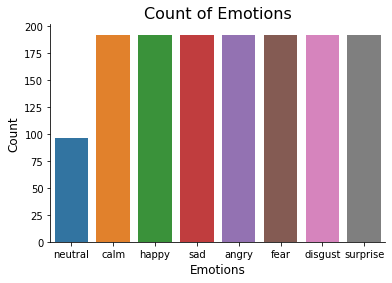

In [5]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

##### Extract features from a python wrapper

In [6]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
#create_waveplot(data, sampling_rate, emotion)
#create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [8]:
# files = data_path['Path'].iloc[0]  # pick files
# smile = opensmile.Smile(
#     feature_set=opensmile.FeatureSet.eGeMAPSv02,
#     feature_level=opensmile.FeatureLevel.Functionals,
# )
# smile.process_files(
#     files,
#     ends=['2s'] * len(files),
#     root=db.root,
# )

In [9]:
file = data_path['Path'].iloc[0]
signal, sampling_rate = audiofile.read(
    file,
    duration=10,
    always_2d=True,
)

In [10]:
signal.shape

(1, 158558)

In [11]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)
smile.feature_names

['F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
 'loudness_sma3_amean',
 'loudness_sma3_stddevNorm',
 'loudness_sma3_percentile20.0',
 'loudness_sma3_percentile50.0',
 'loudness_sma3_percentile80.0',
 'loudness_sma3_pctlrange0-2',
 'loudness_sma3_meanRisingSlope',
 'loudness_sma3_stddevRisingSlope',
 'loudness_sma3_meanFallingSlope',
 'loudness_sma3_stddevFallingSlope',
 'spectralFlux_sma3_amean',
 'spectralFlux_sma3_stddevNorm',
 'mfcc1_sma3_amean',
 'mfcc1_sma3_stddevNorm',
 'mfcc2_sma3_amean',
 'mfcc2_sma3_stddevNorm',
 'mfcc3_sma3_amean',
 'mfcc3_sma3_stddevNorm',
 'mfcc4_

In [13]:
smile.process_signal(
    signal,
    sampling_rate
).iloc[0].values.shape

(88,)

In [42]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)

def get_features(path):
    signal, sampling_rate = audiofile.read(path,
    duration=10,
    always_2d=True)
    
    features_df = smile.process_signal(signal, sampling_rate)
    features = features_df.iloc[0].values
    features = np.expand_dims(features, axis=0)
    return features


##### feature extractor for low-level descriptors (LLDs).

In [ ]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)
smile.process_signal(
    signal,
    sampling_rate
)

### Normalizing and splitting the data for training and testing

In [43]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    #print(path)
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)


data\Actor_01\03-01-01-01-01-01-01.wav
data\Actor_01\03-01-01-01-01-02-01.wav
data\Actor_01\03-01-01-01-02-01-01.wav
data\Actor_01\03-01-01-01-02-02-01.wav
data\Actor_01\03-01-02-01-01-01-01.wav
data\Actor_01\03-01-02-01-01-02-01.wav
data\Actor_01\03-01-02-01-02-01-01.wav
data\Actor_01\03-01-02-01-02-02-01.wav
data\Actor_01\03-01-02-02-01-01-01.wav
data\Actor_01\03-01-02-02-01-02-01.wav
data\Actor_01\03-01-02-02-02-01-01.wav
data\Actor_01\03-01-02-02-02-02-01.wav
data\Actor_01\03-01-03-01-01-01-01.wav
data\Actor_01\03-01-03-01-01-02-01.wav
data\Actor_01\03-01-03-01-02-01-01.wav
data\Actor_01\03-01-03-01-02-02-01.wav
data\Actor_01\03-01-03-02-01-01-01.wav
data\Actor_01\03-01-03-02-01-02-01.wav
data\Actor_01\03-01-03-02-02-01-01.wav
data\Actor_01\03-01-03-02-02-02-01.wav
data\Actor_01\03-01-04-01-01-01-01.wav
data\Actor_01\03-01-04-01-01-02-01.wav
data\Actor_01\03-01-04-01-02-01-01.wav
data\Actor_01\03-01-04-01-02-02-01.wav
data\Actor_01\03-01-04-02-01-01-01.wav
data\Actor_01\03-01-04-02

In [45]:
len(X), len(Y), data_path.Path.shape

(1440, 1440, (1440,))

In [46]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,79,80,81,82,83,84,85,86,87,labels
0,24.263882,0.104171,21.653507,23.907377,27.101028,5.447521,104.436607,113.437279,31.389975,8.258446,...,0.011220,0.005713,2.127660,0.925926,0.336667,0.226912,0.540000,0.480260,-47.939644,neutral
1,25.167887,0.103561,23.178244,25.003677,27.699860,4.521616,56.695068,18.043522,9.703037,9.479506,...,0.012741,0.005434,2.409639,1.223242,0.257500,0.089826,0.535000,0.485206,-47.342331,neutral
2,24.186604,0.103495,22.353910,23.728384,27.093285,4.739374,209.152679,255.810944,13.067581,11.153270,...,0.014029,0.007729,2.153846,0.630915,0.545000,0.175000,0.676667,0.414836,-45.849762,neutral
3,24.268759,0.096042,22.443832,24.478970,26.744179,4.300346,159.005051,128.233871,31.331650,10.120676,...,0.012169,0.008324,2.222222,0.977199,0.333333,0.267374,0.500000,0.445702,-46.193146,neutral
4,24.898130,0.117897,22.419266,24.678062,28.138033,5.718767,214.876053,234.977615,32.979195,25.259745,...,0.010664,0.007934,2.840909,1.440922,0.182000,0.116172,0.408333,0.441717,-50.563885,calm


In [47]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [48]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [49]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1080, 88), (1080, 8), (360, 88), (360, 8))

In [50]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1080, 88), (1080, 8), (360, 88), (360, 8))

In [51]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1080, 88, 1), (1080, 8), (360, 88, 1), (360, 8))

### Modelling

In [52]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 88, 256)           1536      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 44, 256)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 44, 256)           327936    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 22, 256)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 22, 128)           163968    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 11, 128)         

In [53]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
17/17 [==============================] - 2s 71ms/step - loss: 2.0857 - accuracy: 0.1407 - val_loss: 2.0626 - val_accuracy: 0.1472 - lr: 0.0010
Epoch 2/50
17/17 [==============================] - 1s 66ms/step - loss: 2.0289 - accuracy: 0.1704 - val_loss: 1.9929 - val_accuracy: 0.1889 - lr: 0.0010
Epoch 3/50
17/17 [==============================] - 1s 63ms/step - loss: 1.9594 - accuracy: 0.2259 - val_loss: 1.9500 - val_accuracy: 0.2889 - lr: 0.0010
Epoch 4/50
17/17 [==============================] - 1s 64ms/step - loss: 1.9374 - accuracy: 0.2315 - val_loss: 1.9165 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 5/50
17/17 [==============================] - 1s 66ms/step - loss: 1.8870 - accuracy: 0.2389 - val_loss: 1.8468 - val_accuracy: 0.3111 - lr: 0.0010
Epoch 6/50
17/17 [==============================] - 1s 64ms/step - loss: 1.8676 - accuracy: 0.2352 - val_loss: 1.8272 - val_accuracy: 0.3194 - lr: 0.0010
Epoch 7/50
17/17 [==============================] - 1s 67ms/step - loss: 1.8

12/12 [==============================] - 0s 9ms/step - loss: 1.7035 - accuracy: 0.5139
Accuracy of our model on test data :  51.38888955116272 %


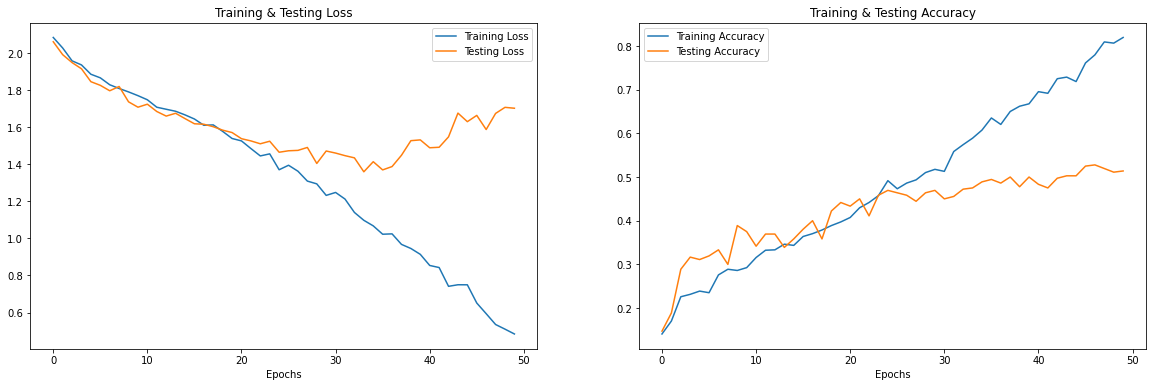

In [54]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [55]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [56]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(20)

,Predicted Labels,Actual Labels
0,angry,angry
1,fear,fear
2,surprise,surprise
3,angry,angry
4,happy,sad
5,neutral,calm
6,calm,calm
7,surprise,fear
8,neutral,disgust
9,disgust,disgust


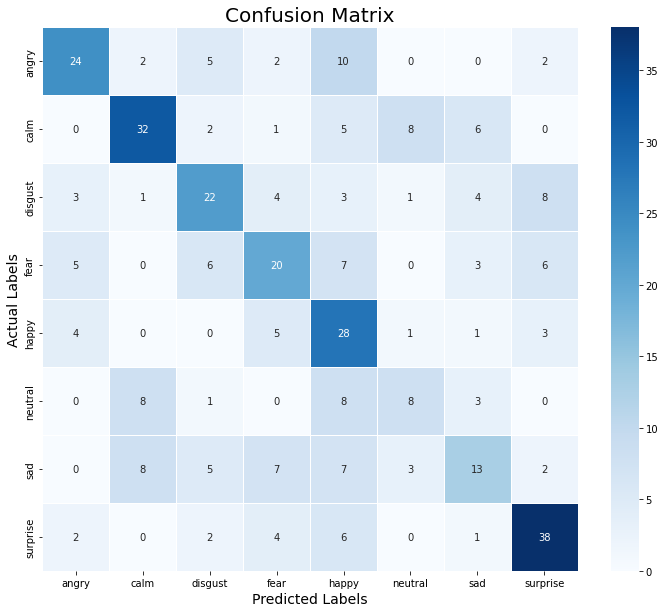

In [57]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.63      0.53      0.58        45
        calm       0.63      0.59      0.61        54
     disgust       0.51      0.48      0.49        46
        fear       0.47      0.43      0.44        47
       happy       0.38      0.67      0.48        42
     neutral       0.38      0.29      0.33        28
         sad       0.42      0.29      0.34        45
    surprise       0.64      0.72      0.68        53

    accuracy                           0.51       360
   macro avg       0.51      0.50      0.49       360
weighted avg       0.52      0.51      0.51       360



##### Open Smile Command line

In [68]:
open_df = pd.read_csv(r'C:\Courses\Autumn_21\Speech_Recognition\Project\asr-sentiment-analysis\opensmile.csv', delimiter=';')
open_df.drop(columns=['name'], inplace=True)

In [69]:
open_df.head()

,frameTime,pcm_fftMag_mfcc[0],pcm_fftMag_mfcc[1],pcm_fftMag_mfcc[2],pcm_fftMag_mfcc[3],pcm_fftMag_mfcc[4],pcm_fftMag_mfcc[5],pcm_fftMag_mfcc[6],pcm_fftMag_mfcc[7],pcm_fftMag_mfcc[8],...,pcm_fftMag_mfcc_de_de[3],pcm_fftMag_mfcc_de_de[4],pcm_fftMag_mfcc_de_de[5],pcm_fftMag_mfcc_de_de[6],pcm_fftMag_mfcc_de_de[7],pcm_fftMag_mfcc_de_de[8],pcm_fftMag_mfcc_de_de[9],pcm_fftMag_mfcc_de_de[10],pcm_fftMag_mfcc_de_de[11],pcm_fftMag_mfcc_de_de[12]
0,0.00,-23.07049,2.030756,7.413672,2.343599,12.95300,3.951367,-12.256360,6.144184,-8.286070,...,0.293403,-0.038360,-0.583367,-0.535269,-0.183690,-0.380468,0.168517,1.344051,-0.012021,-0.115626
1,0.01,-17.98096,5.644370,11.964370,-1.536842,14.57418,8.243950,5.661726,13.682430,-0.313880,...,0.677013,0.069768,-0.618851,-1.478529,-0.734541,-1.085384,0.410825,2.749966,-0.346712,0.089556
2,0.02,-20.45267,7.427081,8.830535,-1.612209,18.80252,12.960190,0.205168,15.036930,6.664619,...,0.707407,-0.215061,-0.630674,-1.691435,-1.203083,-1.528208,0.724808,3.455732,-0.648291,0.406813
3,0.03,-21.51124,0.639524,3.532509,-1.779571,12.48704,1.080153,-1.205060,16.103070,3.705412,...,0.140184,-0.424148,-0.281062,-1.135265,-1.106585,-1.459821,0.385125,1.349831,-0.796718,0.595885
4,0.04,-19.54358,3.674610,9.413149,4.006524,21.79834,8.865157,1.285125,12.131790,-1.135646,...,-0.574781,-1.122927,-0.465781,0.171124,0.314257,-0.126379,-0.236655,-1.661905,-0.241417,0.282469


In [75]:
open_df.mean().values[1:]

array([-1.82550223e+01,  4.64211999e+00,  1.14846911e+01, -6.74088832e+00,
        7.84593845e+00,  7.58870162e+00, -5.83126793e+00,  9.99347641e+00,
       -9.87040269e-01,  3.95086154e+00,  4.48001582e+00, -5.16930051e+00,
        1.15662419e+02,  1.81499617e-02,  1.52286607e-02,  1.91690367e-02,
       -1.11565448e-02,  2.60185679e-02,  2.67029634e-02,  5.91677369e-02,
        2.29501393e-02, -7.66010737e-03,  1.15345089e-02,  3.53782723e-02,
        3.44179842e-02,  4.21410387e-02, -4.92391829e-03, -4.45098821e-03,
        8.37229095e-03,  8.75466272e-03,  4.56114941e-03, -6.79063565e-03,
       -1.91090409e-02, -2.05838607e-02, -2.90036876e-02, -2.10429166e-03,
        4.04228260e-02,  9.92691354e-03, -2.40933465e-03])

##### Loop for running the above code on multiple files

In [108]:
?subprocess.call

Signature: subprocess.call(*popenargs, timeout=None, **kwargs)
Docstring:
Run command with arguments.  Wait for command to complete or
timeout, then return the returncode attribute.

The arguments are the same as for the Popen constructor.  Example:

retcode = call(["ls", "-l"])
File:      c:\users\arundev\.conda\envs\asr_project\lib\subprocess.py
Type:      function


In [ ]:
cmd = 'C:\\Courses\\Autumn_21\\Speech_Recognition\\opensmile-3.0-win-x64\\opensmile-3.0-win-x64\\bin\\SMILExtract -C C:\\Courses\\Autumn_21\\Speech_Recognition\\opensmile-3.0-win-x64\\opensmile-3.0-win-x64\\config\\mfcc\\MFCC12_0_D_A.conf -I C:\\Courses\\Autumn_21\\Speech_Recognition\\Project\\asr-sentiment-analysis\\data\\Actor_01\\03-01-01-01-01-01-01.wav -csvoutput test1.csv"'

In [147]:
k = "C:\\Courses\\Autumn_21\\Speech_Recognition\\opensmile-3.0-win-x64\\opensmile-3.0-win-x64\\bin\\SMILExtract -C config/mfcc/MFCC12_0_D_A.conf -I data/Actor_01/03-01-01-01-01-01-01.wav -csvoutput test1.csv"
out = subprocess.run(k, shell=True,capture_output=True, text=True)
out.stderr

"(MSG) [2] SMILExtract: openSMILE starting!\n(MSG) [2] SMILExtract: config file is: config/mfcc/MFCC12_0_D_A.conf\n(MSG) [2] cComponentManager: successfully registered 103 component types.\n(MSG) [2] instance 'lldarffsink': No filename given, disabling this sink component.\n(MSG) [2] cComponentManager: successfully finished createInstances (14 component instances were finalised, 1 data memories were finalised)\n(MSG) [2] cComponentManager: starting single thread processing loop\n(MSG) [2] cComponentManager: Processing finished! System ran for 339 ticks.\n"

In [206]:
import subprocess
import shutil

def get_opensmile_features_mfcc(path):
    if os.path.exists('feature_folder'):
        shutil.rmtree('feature_folder')
        #print('Folder removed')
        
    os.makedirs('feature_folder', exist_ok=True)
    
    filename = path.split('\\')[-1]
    
    smile_exe = 'C:\\Courses\\Autumn_21\\Speech_Recognition\\opensmile-3.0-win-x64\\opensmile-3.0-win-x64\\bin\\SMILExtract'
    #cmd = smile_exe + ' ' + '-C config/mfcc/MFCC12_0_D_A.conf' + ' -I ' + path + ' -csvoutput feature_folder/{}.csv'.format(filename)
    cmd = smile_exe + ' ' + '-C config/is09-13/IS09_emotion.conf' + ' -I ' + path + ' -csvoutput feature_folder/{}.csv'.format(filename)
    out = subprocess.run(cmd, shell=True,capture_output=True, text=True)
    
    df = pd.read_csv(r'feature_folder/{}.csv'.format(filename), delimiter=';')
    features = df.mean().values[1:]
    #features = np.expand_dims( , axis=0)
    return features
    
#get_opensmile_features_mfcc(data_path.Path[0])

In [230]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    #print(path)
    feature = get_opensmile_features_mfcc(path)
    X.append(feature)
    Y.append(emotion)


In [231]:
len(X), len(Y), data_path.Path.shape

(1440, 1440, (1440,))

In [232]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,375,376,377,378,379,380,381,382,383,labels
0,0.001320,1.187001e-07,0.001320,107.0,1.0,0.000168,-3.615529e-07,0.000227,7.073035e-08,0.000268,...,208.0,212.0,2.925381e-09,-0.000299,0.048521,42.46436,6.516529,-0.074707,36.79996,neutral
1,0.001370,2.369859e-07,0.001370,120.0,3.0,0.000173,-3.288208e-07,0.000227,8.198445e-08,0.000288,...,213.0,216.0,-2.889922e-09,-0.000173,0.028505,16.88779,4.109509,-0.010057,31.16646,neutral
2,0.003140,0.000000e+00,0.003140,143.0,289.0,0.000242,-4.680516e-07,0.000317,2.353186e-07,0.000487,...,110.0,113.0,5.905104e-09,-0.000406,0.065432,82.89360,9.104671,-0.000379,29.76722,neutral
3,0.003245,4.039461e-07,0.003244,140.0,83.0,0.000244,-4.935154e-07,0.000321,2.547821e-07,0.000507,...,204.0,207.0,1.218753e-08,-0.000206,0.032130,36.38341,6.031895,-0.007307,57.67255,neutral
4,0.001355,0.000000e+00,0.001355,133.0,47.0,0.000126,-2.029967e-07,0.000161,4.516604e-08,0.000214,...,166.0,170.0,-2.597059e-09,-0.000666,0.116276,92.37014,9.611175,-0.110826,16.65798,calm


In [233]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [234]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [235]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1080, 384), (1080, 8), (360, 384), (360, 8))

In [236]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1080, 384), (1080, 8), (360, 384), (360, 8))

In [237]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1080, 384, 1), (1080, 8), (360, 384, 1), (360, 8))

### Modelling

In [238]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 384, 256)          1536      
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 192, 256)         0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, 192, 256)          327936    
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 96, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 96, 128)           163968    
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 48, 128)         

In [239]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
17/17 [==============================] - 8s 439ms/step - loss: 2.0721 - accuracy: 0.1287 - val_loss: 2.0594 - val_accuracy: 0.1333 - lr: 0.0010
Epoch 2/100
17/17 [==============================] - 7s 420ms/step - loss: 2.0217 - accuracy: 0.1704 - val_loss: 1.9999 - val_accuracy: 0.2167 - lr: 0.0010
Epoch 3/100
17/17 [==============================] - 7s 414ms/step - loss: 1.9627 - accuracy: 0.2204 - val_loss: 1.8763 - val_accuracy: 0.3250 - lr: 0.0010
Epoch 4/100
17/17 [==============================] - 7s 429ms/step - loss: 1.8572 - accuracy: 0.2648 - val_loss: 1.7948 - val_accuracy: 0.3417 - lr: 0.0010
Epoch 5/100
17/17 [==============================] - 7s 421ms/step - loss: 1.8563 - accuracy: 0.2602 - val_loss: 1.8067 - val_accuracy: 0.3306 - lr: 0.0010
Epoch 6/100
17/17 [==============================] - 7s 435ms/step - loss: 1.8324 - accuracy: 0.2667 - val_loss: 1.8030 - val_accuracy: 0.3472 - lr: 0.0010
Epoch 7/100
17/17 [==============================] - 7s 426ms/st

12/12 [==============================] - 1s 51ms/step - loss: 1.7770 - accuracy: 0.4194
Accuracy of our model on test data :  41.94444417953491 %


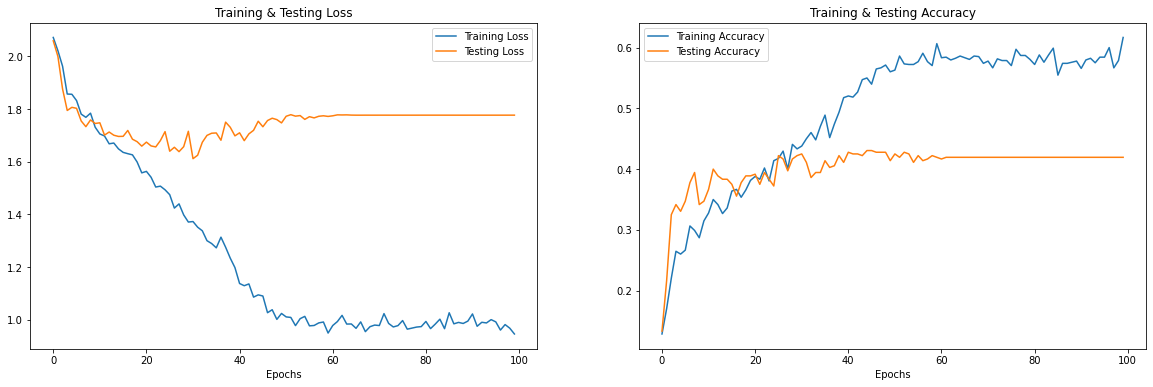

In [241]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [242]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [243]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(20)

,Predicted Labels,Actual Labels
0,angry,angry
1,angry,fear
2,angry,surprise
3,angry,angry
4,calm,sad
5,calm,calm
6,sad,calm
7,sad,fear
8,calm,disgust
9,sad,disgust


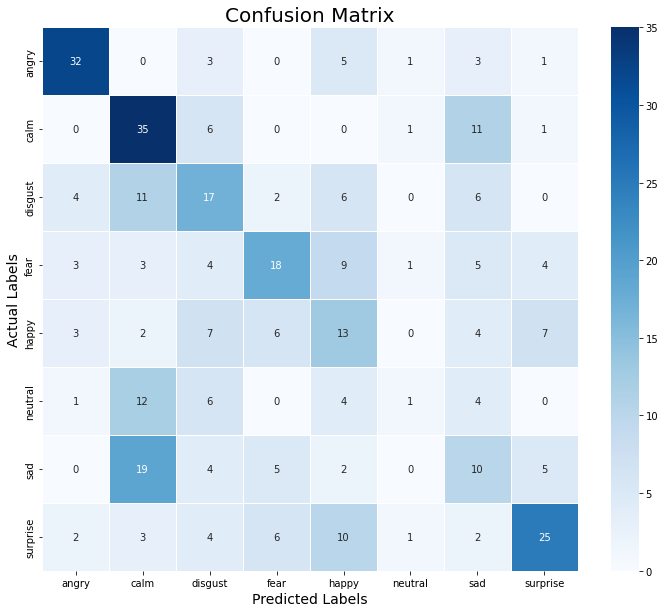

In [244]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [245]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.71      0.71      0.71        45
        calm       0.41      0.65      0.50        54
     disgust       0.33      0.37      0.35        46
        fear       0.49      0.38      0.43        47
       happy       0.27      0.31      0.29        42
     neutral       0.20      0.04      0.06        28
         sad       0.22      0.22      0.22        45
    surprise       0.58      0.47      0.52        53

    accuracy                           0.42       360
   macro avg       0.40      0.39      0.39       360
weighted avg       0.42      0.42      0.41       360



##### Combining pre-defined and python wrapper opensmile feature

In [250]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

In [251]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)

In [258]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    signal, sampling_rate = audiofile.read(path,
    duration=10,
    always_2d=True)
    
    features_df = smile.process_signal(signal, sampling_rate)
    res4 = features_df.iloc[0].values
    res4 = np.expand_dims(res4, axis=0)
    
    return result, res4

### Normalizing and splitting the data for training and testing

In [259]:
X, Y, Z = [], [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature, res4 = get_features(path)
    print(feature.shape)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
        
    for ele in res4:
        X.append(ele)
        Y.append(emotion)

(3, 162)
(1, 88)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 162 and the array at index 1 has size 88

In [47]:
len(X), len(Y), data_path.Path.shape

(4320, 4320, (1440,))

In [48]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.300781,0.706492,0.756853,0.735217,0.731014,0.715156,0.667529,0.673754,0.722173,0.748969,...,4.319263e-06,0.000003,0.000002,2.286677e-06,5.131693e-06,8.065748e-06,0.000005,2.270858e-06,1.642365e-07,neutral
1,0.287561,0.777965,0.780274,0.778945,0.794249,0.746320,0.656998,0.694907,0.737588,0.751964,...,7.810265e-06,0.000007,0.000006,5.790992e-06,8.921459e-06,1.220891e-05,0.000009,5.885410e-06,3.718549e-06,neutral
2,0.176693,0.640605,0.712837,0.743736,0.714797,0.701402,0.694569,0.663853,0.688527,0.742508,...,7.999367e-07,0.000001,0.000001,5.350822e-07,3.480663e-07,8.398364e-07,0.000001,4.287777e-07,2.878995e-08,neutral
3,0.271272,0.674966,0.723259,0.724594,0.681302,0.670643,0.674574,0.630036,0.680146,0.708276,...,6.998011e-06,0.000007,0.000007,6.999257e-06,1.217880e-05,9.449918e-06,0.000008,2.638513e-06,1.788902e-07,neutral
4,0.283077,0.732370,0.774408,0.762864,0.747799,0.758746,0.726973,0.637400,0.682552,0.713579,...,1.579935e-05,0.000016,0.000015,1.535486e-05,2.004131e-05,1.791442e-05,0.000017,1.142335e-05,8.881086e-06,neutral


In [49]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [50]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [51]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [52]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [53]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

### Modelling

In [54]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

In [55]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 [==============================] - 5s 96ms/step - loss: 2.0175 - accuracy: 0.1904 - val_loss: 1.9419 - val_accuracy: 0.2306 - lr: 0.0010
Epoch 2/50
51/51 [==============================] - 5s 99ms/step - loss: 1.9572 - accuracy: 0.2188 - val_loss: 1.8662 - val_accuracy: 0.3028 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - 5s 96ms/step - loss: 1.8888 - accuracy: 0.2534 - val_loss: 1.7607 - val_accuracy: 0.3398 - lr: 0.0010
Epoch 4/50
51/51 [==============================] - 5s 90ms/step - loss: 1.8463 - accuracy: 0.2907 - val_loss: 1.7448 - val_accuracy: 0.3481 - lr: 0.0010
Epoch 5/50
51/51 [==============================] - 5s 90ms/step - loss: 1.8067 - accuracy: 0.2858 - val_loss: 1.6400 - val_accuracy: 0.3796 - lr: 0.0010
Epoch 6/50
51/51 [==============================] - 5s 91ms/step - loss: 1.7386 - accuracy: 0.3173 - val_loss: 1.6898 - val_accuracy: 0.3565 - lr: 0.0010
Epoch 7/50
51/51 [==============================] - 5s 100ms/step - loss: 1.

34/34 [==============================] - 0s 13ms/step - loss: 1.3176 - accuracy: 0.6741
Accuracy of our model on test data :  67.40740537643433 %


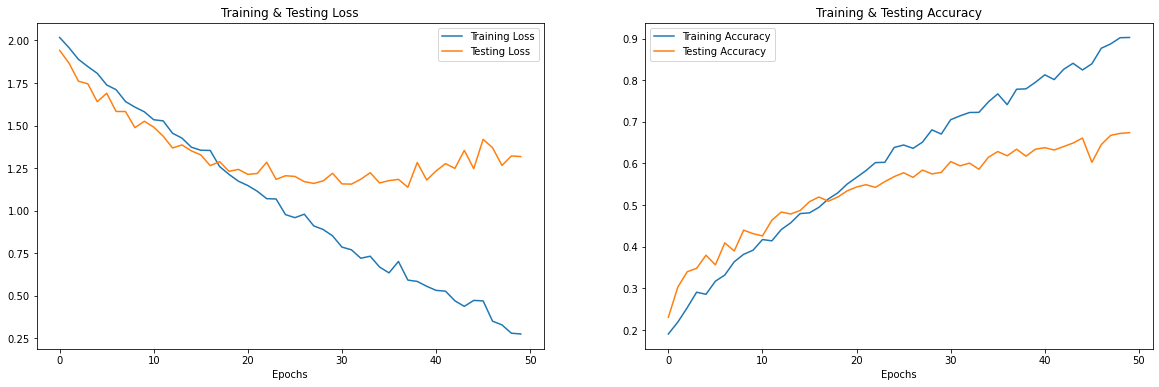

In [56]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [57]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [58]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(20)

,Predicted Labels,Actual Labels
0,fear,fear
1,happy,angry
2,fear,fear
3,calm,calm
4,angry,angry
5,surprise,surprise
6,fear,fear
7,fear,happy
8,fear,fear
9,neutral,sad


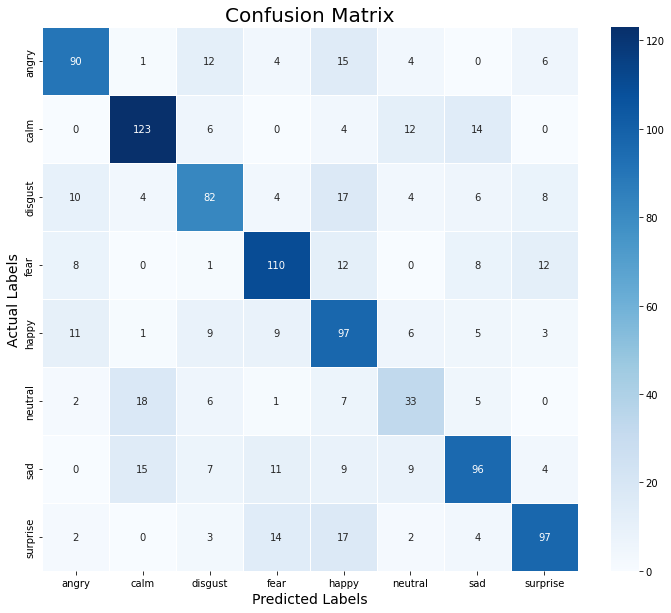

In [59]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.73      0.68      0.71       132
        calm       0.76      0.77      0.77       159
     disgust       0.65      0.61      0.63       135
        fear       0.72      0.73      0.72       151
       happy       0.54      0.69      0.61       141
     neutral       0.47      0.46      0.46        72
         sad       0.70      0.64      0.66       151
    surprise       0.75      0.70      0.72       139

    accuracy                           0.67      1080
   macro avg       0.66      0.66      0.66      1080
weighted avg       0.68      0.67      0.67      1080

